In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


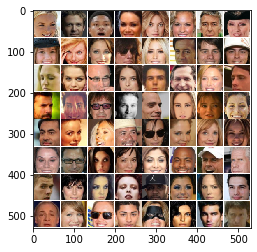

torch.Size([64, 3, 64, 64])


In [4]:
### LOAD DATA ###

dataloader, imsize = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
### LOAD MODEL ###

gen = models.DCGenerator(ngpu=1, ngf=128, nz=100, nc=3)
gen.load_state_dict(torch.load("/home/shared/phase-retrieval/models/DCGAN_CelebA/netG_epoch_99.pth"));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


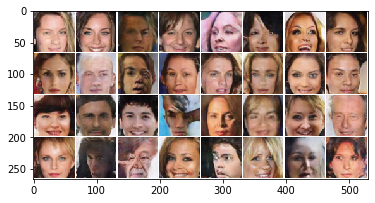

In [6]:
### Test model ###

gen.to(device)
plot_grid(gen(torch.randn((32, 100, 1, 1), device=device)).cpu().detach()*0.5+0.5)

In [7]:
def add_noise(magn, device, alpha=1):
    magn_sq = magn**2
    noise = torch.randn(*magn.shape, device=device)
    # scale noise by standard deviation
    # we want to have variance Diag(alpha**2*magn_sq) for vec(noise)
    noisy_magn = magn_sq+noise*magn*alpha
    return torch.sqrt(noisy_magn)

def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft**2, -1) + 1e-16)
    return mags

In [18]:
# Latent z optimization

def genopt(sample_magn, gen, device, steps=5000, lr=1.0, z_shape=(100, 1, 1)):

    gen.to(device)
    gen.eval()

    N = sample_magn.shape[0]
    z = torch.randn((N, *z_shape), requires_grad=True, device=device) 
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(z, unit_interval=True)
    
    with tqdm_notebook(total=steps) as progress_bar:
        for i in range(steps):
            magn = calc_mags(last_out)

            mse_all = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            loss = torch.sum(mse_all)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_out = gen(z, unit_interval=True)

            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(1)
    
    return last_out.detach(), losses, mse_all


Batch 1/1 finished


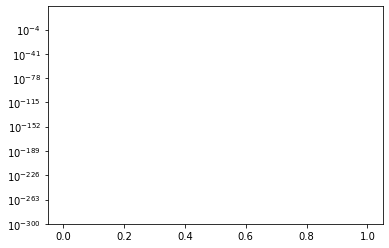

In [19]:
### Test one sample Fourier magnitudes random init + multiple restarts ###

num_batches = 1 # 16
batch_size = 64
steps = 100
alpha = 1.0
lr = 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magn_noise = add_noise(calc_mags(test_sample), device, alpha) 
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = genopt(sample_magn=test_magn_noise, gen=gen, device=device,
                                                        lr=lr, steps=steps)
        cur_out_results = cur_out_results.cpu().numpy()

        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_noise_1.0_original.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_noise_1.0.p", "wb"))

In [24]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_noise_1.0_original.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_noise_1.0.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


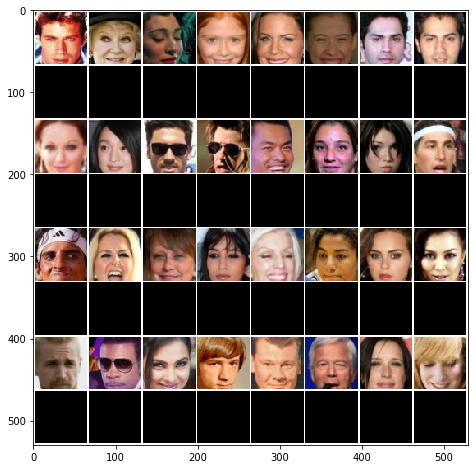

In [20]:
# Benchmark results

print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64), 
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/dcgan/celeba/{0}{1}.png".format('randomInit_noise_1.0_', time.strftime("%Y%m%d_%H%M%S")))

In [21]:
# Benchmark test predictions #

benchmark(pred=out_results, true=out_original, check=["mse", "mae", "ssim", "magn", "imcon"])

/home/alobe101/.local/lib/python3.6/site-packages/skimage/feature/register_translation.py:103: RuntimeWarning: invalid value encountered in cdouble_scalars
  (src_amp * target_amp)


Signal error:
  MSE: 0.27658749541378774, std: 0.12232592843247042
  MAE: 0.4506660214510051, std: 0.1238996955681037
  SSIM: 0.013197837992286134, std: 0.022518137247769035

Magnitude error:
  MSE Magnitude: 1132.9023812148746, std: 501.0470028593989

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.00] - should be in [0, 1]

Markdown table values:
 0.2766 | 0.4507 | 0.01320 | 1133 |


## Evaluation for different z optimizations (64 samples)

| alpha | iterations | lr | MSE | MAE | SSIM | MSE Magnitude |
| --- | --- | --- | --- | --- | --- | --- |
| 0.0 | 1000 | 1.0
| 0.01 |
| 0.1 |
| 1.0 | 

## Final Evaluation (1024 samples)

| alpha | iterations | lr | MSE | MAE | SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- |
| 0.0 | 1000 | 1.0
| 0.01 |
| 0.1 |
| 1.0 | 
